In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

##### Read the data and define types of each cluster

In [2]:
players_new_types = pd.read_csv('../Data/players_new_types.csv')
#display(players_new_types)

results_clusters = pd.read_csv('../Data/results_clusters.csv')
#display(results_clusters)

players_new_types['Cluster'] = players_new_types['Cluster'].apply(lambda x: 'Spot Up Wing' if x == 0 else x)
players_new_types['Cluster'] = players_new_types['Cluster'].apply(lambda x: 'All Offensive' if x == 1 else x)
players_new_types['Cluster'] = players_new_types['Cluster'].apply(lambda x: 'Rim Runners' if x == 2 else x)
players_new_types['Cluster'] = players_new_types['Cluster'].apply(lambda x: 'Post Up Big' if x == 3 else x)
players_new_types['Cluster'] = players_new_types['Cluster'].apply(lambda x: 'On Ball Handler' if x == 4 else x)
players_new_types['Cluster'] = players_new_types['Cluster'].apply(lambda x: 'Spot Up Big' if x == 5 else x)
#display(players_new_types.head())

results_clusters['Cluster'] = results_clusters['Cluster'].apply(lambda x: 'Spot Up Wing' if x == 0 else x)
results_clusters['Cluster'] = results_clusters['Cluster'].apply(lambda x: 'All Offensive' if x == 1 else x)
results_clusters['Cluster'] = results_clusters['Cluster'].apply(lambda x: 'Rim Runners' if x == 2 else x)
results_clusters['Cluster'] = results_clusters['Cluster'].apply(lambda x: 'Post Up Big' if x == 3 else x)
results_clusters['Cluster'] = results_clusters['Cluster'].apply(lambda x: 'On Ball Handler' if x == 4 else x)
results_clusters['Cluster'] = results_clusters['Cluster'].apply(lambda x: 'Spot Up Big' if x == 5 else x)

#display(results_clusters)

##### Heat Map of the characteristics in each cluster

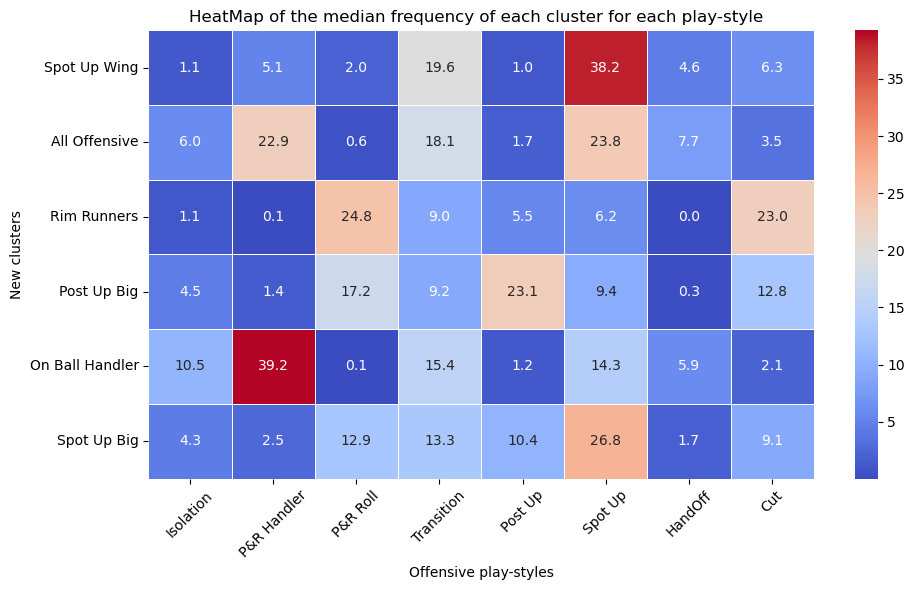

In [3]:
df = results_clusters.drop(columns=["Cluster"])

plt.figure(figsize=(10, 6))
sns.heatmap(df.iloc[:, 1:], cmap="coolwarm", annot=True, fmt=".1f", linewidths=0.5,yticklabels=results_clusters["Cluster"])

plt.xlabel("Offensive play-styles")
plt.ylabel("New clusters")
plt.title("HeatMap of the median frequency of each cluster for each play-style  ")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

##### How many players of each type?

In [4]:
def pct_players_of_each_type(season):
    new_dt = players_new_types[players_new_types['Season']==season]

    new_dt=new_dt.groupby('Cluster').size().reset_index(name='# of players')
    total_sum = new_dt['# of players'].sum()
    new_dt['% of players'] = ((new_dt['# of players'] / total_sum) * 100).round(2)
    return new_dt

s_2019=pct_players_of_each_type(2019)
s_2020=pct_players_of_each_type(2020)
#display(s_2019)
#display(s_2020)

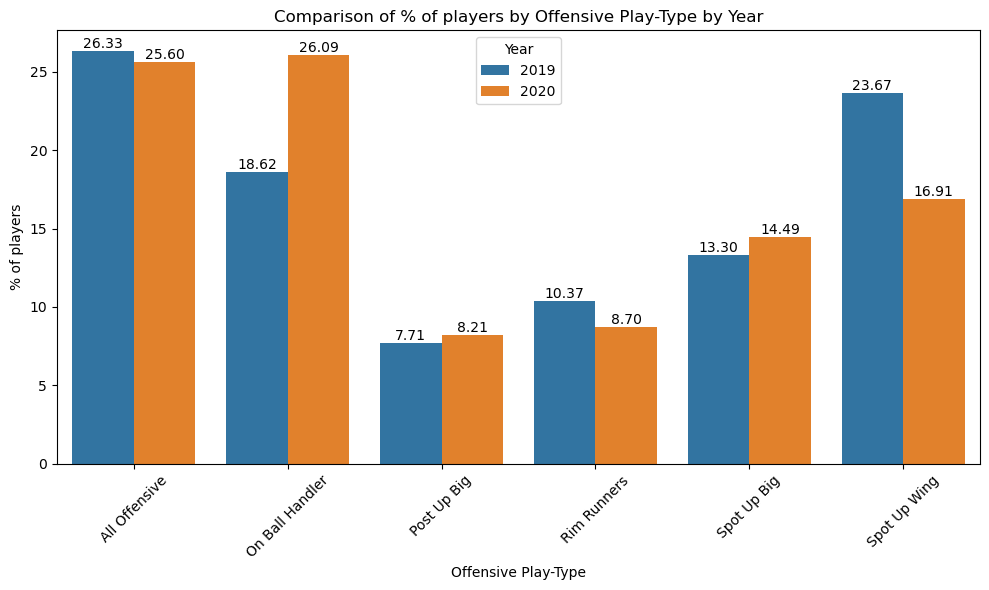

In [5]:
s_2020['Año'] = 2020
s_2019['Año'] = 2019
df = pd.concat([s_2019, s_2020])


plt.figure(figsize=(10, 6))
ax=sns.barplot(x='Cluster', y='% of players', hue='Año', data=df)


plt.xlabel('Offensive Play-Type')
plt.ylabel('% of players')
plt.title('Comparison of % of players by Offensive Play-Type by Year')
plt.xticks(rotation=45) 

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')

plt.legend(title='Year')
plt.tight_layout()
plt.savefig('../img/Barchart comparison.png')
plt.show()

##### Analyse Spot-Ups (Wings & Bigs)

In [20]:
from bs4 import BeautifulSoup
from urllib.request import urlopen

# Function to extract data from Basketball Reference
def single(season,stats):
  url = f'https://www.basketball-reference.com/leagues/NBA_{season}_{stats}.html'
  table_html = BeautifulSoup(urlopen(url), 'html.parser').findAll('table')
  df = pd.read_html(str(table_html))[0]
  df = df.drop(df[df.Player == 'Player'].index) # drop row contains table header
  df = df.drop('Rk', axis=1) # drop Rk columns
  df.Player = df.Player.str.replace('*','',regex=False) # remove asterisk on player's name
  df.insert(0,'Season',season) # insert season column
  df = df.apply(pd.to_numeric, errors='coerce').fillna(df) # convert non string values to numeric
  return df

# Stats per game from 2019 Season
br_2019=single(2019,'per_game')

br_2019.to_csv('../Data/br_2019_per_game.csv', index=False)

In [45]:
# Filter per Spot Up Players
spotups = players_new_types[(players_new_types['Cluster'] == 'Spot Up Wing') | (players_new_types['Cluster'] == 'Spot Up Big')]

# Season 2019
spotups = spotups[spotups['Season']==2019]

# Get no duplicates players
br_2019_no_duplicates = br_2019.drop_duplicates(subset="Player", keep="first")

# Merge both dataframes
merged_spotups = pd.merge(spotups, br_2019_no_duplicates, left_on="PLAYER", right_on="Player", how="inner", indicator=True)


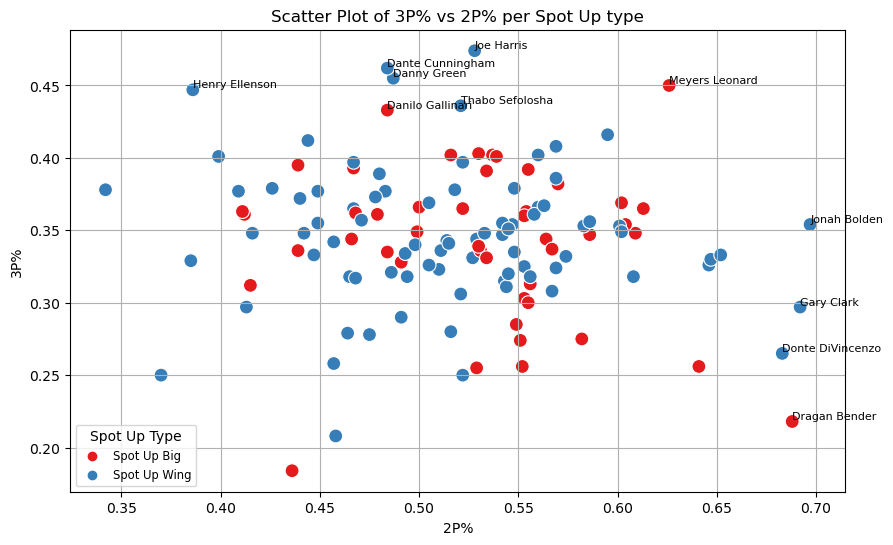

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_spotups, x='2P%', y='3P%', hue='Cluster', palette='Set1', s=100)

threshold_3P = 0.42 
threshold_2P = 0.66 

for i, row in merged_spotups.iterrows():
    if row['3P%'] > threshold_3P or row['2P%'] > threshold_2P:
        plt.text(row['2P%'], row['3P%'], row['Player'], fontsize=8, ha='left', va='bottom')

plt.title('Scatter Plot of 3P% vs 2P% per Spot Up type')
plt.xlabel('2P%')
plt.ylabel('3P%')

plt.legend(title='Spot Up Type',loc='lower left', fontsize='small')
plt.grid(True)
plt.savefig('../img/ScatterPlotSpotUp.png')
plt.show()

- Which team has the most players of each type?

In [14]:
n = players_new_types.groupby(['TEAM', 'Cluster','Season']).size().reset_index(name='# of players')
display(n)


,TEAM,Cluster,Season,# of players
0,ATL,All Offensive,2019,5
1,ATL,All Offensive,2020,3
2,ATL,On Ball Handler,2019,1
3,ATL,On Ball Handler,2020,2
4,ATL,Rim Runners,2020,2
...,...,...,...,...
274,WAS,Rim Runners,2019,2
275,WAS,Rim Runners,2020,1
276,WAS,Spot Up Big,2019,3
277,WAS,Spot Up Big,2020,1


In [43]:
# Encontrar el valor máximo de jugadores por cluster
max_jugadores_por_cluster = n.groupby('Cluster')['# of players'].max()

# Filtrar los equipos que tienen el valor máximo
equipos_con_mas_jugadores = n[n.set_index(['Cluster', '# of players']).index.isin(max_jugadores_por_cluster.items())]

# Mostrar el resultado
display(equipos_con_mas_jugadores.sort_values(by='Cluster').head())


atl = players_new_types[players_new_types['TEAM']=='PHX']
display(atl.head())




,TEAM,Cluster,Season,# of players
213,PHX,All Offensive,2019,6
44,CLE,On Ball Handler,2019,5
234,SAC,Post Up Big,2019,2
204,PHI,Post Up Big,2019,2
37,CHI,Post Up Big,2019,2


,PLAYER,TEAM,ISOLATION_FREQ,PNR_HANDLER_FREQ,PNR_ROLL_FREQ,TRANSITION_FREQ,POST_UP_FREQ,SPOT_UP_FREQ,HANDOFF_FREQ,CUT_FREQ,Season,Cluster
7,Devin Booker,PHX,0.125,0.345,0.000,0.197,0.040,0.068,0.049,0.028,2019,On Ball Handler
48,T.J. Warren,PHX,0.059,0.162,0.000,0.225,0.024,0.312,0.025,0.055,2019,All Offensive
62,Deandre Ayton,PHX,0.027,0.000,0.211,0.062,0.285,0.041,0.000,0.158,2019,Post Up Big
76,Kelly Oubre Jr.,PHX,0.029,0.201,0.000,0.221,0.000,0.276,0.049,0.056,2019,All Offensive
128,Josh Jackson,PHX,0.053,0.235,0.000,0.182,0.012,0.298,0.056,0.041,2019,All Offensive


# RADAR PLOTS

Comparació radar, extreure dades avançades de basketball reference

## ALL OFFENSIVE

In [66]:
all_off = players_new_types[players_new_types['Cluster']=='All Offensive']
display(all_off.head(20))

,PLAYER,TEAM,ISOLATION_FREQ,PNR_HANDLER_FREQ,PNR_ROLL_FREQ,TRANSITION_FREQ,POST_UP_FREQ,SPOT_UP_FREQ,HANDOFF_FREQ,CUT_FREQ,Season,Cluster
1,Paul George,OKC,0.134,0.245,0.014,0.206,0.036,0.117,0.054,0.019,2019,All Offensive
5,Stephen Curry,GSW,0.056,0.216,0.023,0.200,0.000,0.130,0.055,0.045,2019,All Offensive
8,Kevin Durant,GSW,0.156,0.190,0.021,0.211,0.106,0.088,0.037,0.040,2019,All Offensive
12,Bradley Beal,WAS,0.094,0.253,0.000,0.209,0.005,0.133,0.064,0.053,2019,All Offensive
30,Buddy Hield,SAC,0.058,0.164,0.000,0.261,0.000,0.188,0.081,0.036,2019,All Offensive
32,Tobias Harris,PHI,0.093,0.188,0.000,0.190,0.068,0.182,0.056,0.058,2019,All Offensive
39,Jimmy Butler,PHI,0.102,0.252,0.000,0.166,0.072,0.105,0.084,0.072,2019,All Offensive
41,Khris Middleton,MIL,0.158,0.196,0.013,0.213,0.091,0.123,0.051,0.018,2019,All Offensive
42,Brandon Ingram,LAL,0.142,0.255,0.000,0.188,0.090,0.130,0.037,0.053,2019,All Offensive
44,Andrew Wiggins,MIN,0.082,0.265,0.000,0.140,0.080,0.164,0.101,0.054,2019,All Offensive


1. Escollim caracteristiques avançades
2. Exportem característiques avançades
3. Exportem salary csv
4. Escollim jugador: Khris Middleton
5. Escollim un jugador amb salari més atl
6. Radar plot dels dos
6. Escollim un jugador amb salari més baixx
7. Radar plot dels dos

In [14]:
from bs4 import BeautifulSoup
from urllib.request import urlopen

def single(season,stats):
  url = f'https://www.basketball-reference.com/leagues/NBA_{season}_{stats}.html'
  table_html = BeautifulSoup(urlopen(url), 'html.parser').findAll('table')
  df = pd.read_html(str(table_html))[0]
  df = df.drop(df[df.Player == 'Player'].index) # drop row contains table header
  df = df.drop('Rk', axis=1) # drop Rk columns
  df.Player = df.Player.str.replace('*','',regex=False) # remove asterisk on player's name
  df.insert(0,'Season',season) # insert season column
  df = df.apply(pd.to_numeric, errors='coerce').fillna(df) # convert non string values to numeric
  return df

df=single(2019,'advanced')

df2=single(2019,'per_game')

,Season,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,...,Unnamed: 19,OWS,DWS,WS,WS/48,Unnamed: 24,OBPM,DBPM,BPM,VORP
0,2019,Álex Abrines,SG,25,OKC,31,588,6.3,0.507,0.809,...,NaN,0.1,0.6,0.6,0.053,NaN,-3.7,0.4,-3.3,-0.2
1,2019,Quincy Acy,PF,28,PHO,10,123,2.9,0.379,0.833,...,NaN,-0.1,0.0,-0.1,-0.022,NaN,-7.6,-0.5,-8.1,-0.2
2,2019,Jaylen Adams,PG,22,ATL,34,428,7.6,0.474,0.673,...,NaN,-0.1,0.2,0.1,0.011,NaN,-3.8,-0.5,-4.3,-0.2
3,2019,Steven Adams,C,25,OKC,80,2669,18.5,0.591,0.002,...,NaN,5.1,4.0,9.1,0.163,NaN,0.7,0.4,1.1,2.1
4,2019,Bam Adebayo,C,21,MIA,82,1913,17.9,0.623,0.031,...,NaN,3.4,3.4,6.8,0.171,NaN,-0.4,2.2,1.8,1.8


Segun ESPN 2018-2019

Middleton salary: 13M
Bradley Beal salary: 25,5M
Malcolm Brogdon: 1.5M


In [64]:
khr_adv =df[df['Player'] == 'Khris Middleton']
khr_adv = khr_adv[['Player','PER','TS%','AST%','USG%','BPM']]

khr_game =df2[df2['Player']=='Khris Middleton']
khr_game = khr_game[['Player','eFG%']]

khr = khr_adv.merge(khr_game, on='Player', how='inner')
display(khr)

beal =df[df['Player'] == 'Bradley Beal']
beal = beal[['Player','PER','TS%','AST%','USG%','BPM']]

beal2 =df2[df2['Player']=='Bradley Beal']
beal2 = beal2[['Player','eFG%']]

beal = beal.merge(beal2, on='Player', how='inner')
display(beal)

combined_df = pd.concat([khr, beal], ignore_index=True)



,Player,PER,TS%,AST%,USG%,BPM,eFG%
0,Khris Middleton,16.5,0.558,20.1,25.1,0.8,0.519


,Player,PER,TS%,AST%,USG%,BPM,eFG%
0,Bradley Beal,20.8,0.581,24.1,28.4,2.9,0.54


In [65]:
import plotly.express as px
import pandas as pd
           
# Define maximum values for each variable
max_values = {'PER': 30,'TS%': 0.682, 'AST%': 46.5, 'USG%': 40.5,'BPM':11,'eFG%': 0.669}

for col in combined_df.columns[1:]:
    combined_df[col] = combined_df[col] / max_values[col]

display(combined_df)

# Melt the DataFrame to reshape it for the radar plot
combined_melted = pd.melt(combined_df, id_vars=['Player'], var_name='variable', value_name='value')

# Create the radar plot
fig = px.line_polar(
    combined_melted,
    r='value',
    theta='variable',
    line_close=True,
    color='Player'  
)
fig.update_traces( # Línea exterior en negro
    fill='toself'  # Rellenar el área
)

# Añadir título al gráfico
fig.update_layout(polar_radialaxis_showticklabels=False, polar_radialaxis_showline=False,title='Comparación de Jugadores en Radar Plot')
fig.show()


,Player,PER,TS%,AST%,USG%,BPM,eFG%
0,Khris Middleton,0.550000,0.818182,0.432258,0.619753,0.072727,0.775785
1,Bradley Beal,0.693333,0.851906,0.518280,0.701235,0.263636,0.807175


c:\Users\Gabriel\anaconda3\Lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

c:\Users\Gabriel\anaconda3\Lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [70]:
khr_adv =df[df['Player'] == 'Khris Middleton']
khr_adv = khr_adv[['Player','PER','TS%','AST%','USG%','BPM']]

khr_game =df2[df2['Player']=='Khris Middleton']
khr_game = khr_game[['Player','eFG%']]

khr = khr_adv.merge(khr_game, on='Player', how='inner')
display(khr)

ing =df[df['Player'] == 'Malcolm Brogdon']
ing = ing[['Player','PER','TS%','AST%','USG%','BPM']]

ing2 =df2[df2['Player']=='Malcolm Brogdon']
ing2 = ing2[['Player','eFG%']]

ing = ing.merge(ing2, on='Player', how='inner')
display(ing)

combined_df = pd.concat([khr, ing], ignore_index=True)

,Player,PER,TS%,AST%,USG%,BPM,eFG%
0,Khris Middleton,16.5,0.558,20.1,25.1,0.8,0.519


,Player,PER,TS%,AST%,USG%,BPM,eFG%
0,Malcolm Brogdon,17.8,0.614,16.2,20.7,2.2,0.575


In [71]:
# Define maximum values for each variable
max_values = {'PER': 30,'TS%': 0.682, 'AST%': 46.5, 'USG%': 40.5,'BPM':11,'eFG%': 0.669}

for col in combined_df.columns[1:]:
    combined_df[col] = combined_df[col] / max_values[col]

display(combined_df)

# Melt the DataFrame to reshape it for the radar plot
combined_melted = pd.melt(combined_df, id_vars=['Player'], var_name='variable', value_name='value')

# Create the radar plot
fig = px.line_polar(
    combined_melted,
    r='value',
    theta='variable',
    line_close=True,
    color='Player'  
)
fig.update_traces( # Línea exterior en negro
    fill='toself'  # Rellenar el área
)

# Añadir título al gráfico
fig.update_layout(polar_radialaxis_showticklabels=False, polar_radialaxis_showline=False,title='Comparación de Jugadores en Radar Plot')
fig.show()

,Player,PER,TS%,AST%,USG%,BPM,eFG%
0,Khris Middleton,0.550000,0.818182,0.432258,0.619753,0.072727,0.775785
1,Malcolm Brogdon,0.593333,0.900293,0.348387,0.511111,0.200000,0.859492


c:\Users\Gabriel\anaconda3\Lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

c:\Users\Gabriel\anaconda3\Lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

